In [1]:
import numpy as np
import pandas as pd 
import random
import torch
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import glob
import shutil
import yaml
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

Seed

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Создание датасета

In [3]:
DIR_PATH = '/kaggle/input/logodet3k/LogoDet-3K'

logo_dataset = pd.DataFrame(glob.glob(f"{DIR_PATH}/*/*/*"), columns=["file_path"])
logo_dataset["extension"] = logo_dataset["file_path"].apply(lambda x: x.split(".")[-1])
logo_dataset["logo_category"] = logo_dataset["file_path"].apply(lambda x: x.split(os.sep)[-3])
logo_dataset["logo_name"] = logo_dataset["file_path"].apply(lambda x: x.split(os.sep)[-2])
logo_dataset.head()

,file_path,extension,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


Фильтрация данных (сокращение набора)

In [4]:
def filter_dataset(logo_dataset:pd.DataFrame = logo_dataset, 
                  q:float = 0.05):
    '''
    Функция для фильтрации (сокращения) исходного датасета.
    В этом есть смысл ввиду предположения избыточности полного набора данных 
    при решении задачи Object Detection c одним классом (logo)

    Параметры:
    -logo_dataset: исходный датасет с логотипами (pd.DataFrame, default: logo_dataset)
    -q: квантиль для подрезки распределения (убрать небольшое число логотипов) (float, default: 0.05)
    '''

    logo_dataset = logo_dataset[logo_dataset['logo_category'] != 'Medical']
    assert logo_dataset['extension'].value_counts()['jpg'] == logo_dataset['extension'].value_counts()['xml']
    logo_dataset = logo_dataset[logo_dataset['logo_category'] != 'Sports']
    assert logo_dataset['extension'].value_counts()['jpg'] == logo_dataset['extension'].value_counts()['xml']
    value_counts = logo_dataset['logo_name'].value_counts()
    threshold = np.quantile(value_counts.values, q = q)
    logo_names_to_remove = value_counts[value_counts < threshold].index
    logo_dataset = logo_dataset[~logo_dataset['logo_name'].isin(logo_names_to_remove)]
    assert logo_dataset['extension'].value_counts()['jpg'] == logo_dataset['extension'].value_counts()['xml']

    return logo_dataset
    
logo_dataset_copy = logo_dataset.copy()
logo_dataset_copy = filter_dataset(logo_dataset = logo_dataset_copy, 
                                  q = 0.25)
print(f"Dataset shape: {logo_dataset_copy.shape}")
print(f"No. of .jpg files {logo_dataset_copy['extension'].value_counts()['jpg']}")
print(f"No. of .xml files {logo_dataset_copy['extension'].value_counts()['xml']}")
logo_dataset_copy.head()
    

Dataset shape: (281440, 4)
No. of .jpg files 140720
No. of .xml files 140720


,file_path,extension,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


Чуть-чуть сократили датасет. Для демонстрационного варианта решения задачи должно хватить. Если будет долго обучаться, то можно сократить ещё

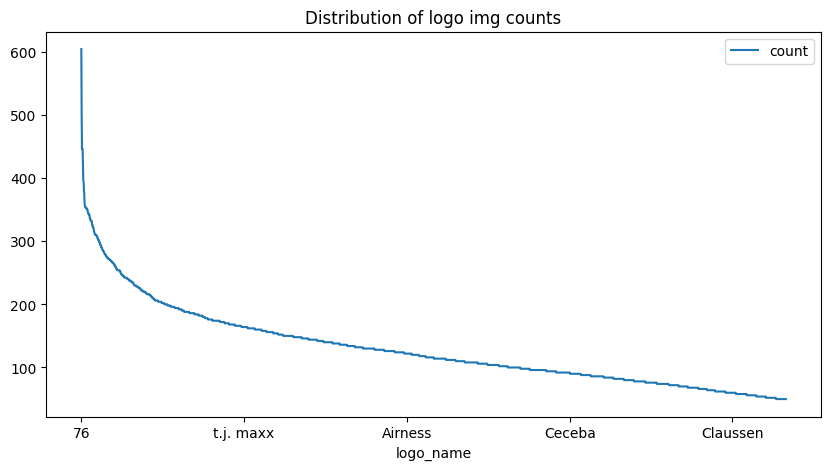

In [5]:
logo_dataset_copy["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")

plt.show()

Далее стоит собрать файл для обучения YOLO (fine-tuning)

In [6]:
dataset_dst_dir = "/kaggle/working/logodet3k"
if os.path.exists(dataset_dst_dir):
    shutil.rmtree(dataset_dst_dir)
os.makedirs(f"{dataset_dst_dir}/train", exist_ok=True)
os.makedirs(f"{dataset_dst_dir}/val", exist_ok=True)

Вспомогательные словари формата ```{'logo_name': label} и {label: 'logo_name'}``` 

In [7]:
classname2idx = {logo_name: idx for idx, logo_name in enumerate(sorted(logo_dataset_copy["logo_name"].unique()))}
idx2classname = {idx: logo_name for logo_name, idx in classname2idx.items()}

# Мы же решаем задачу детекции лого
classname2idx = {"logo": 0}
idx2classname = {0: 'logo'}
print(classname2idx)

{'logo': 0}


In [8]:
class_name_idx_map_str = "\n".join([f"    {idx}: {class_name}" for class_name, idx in classname2idx.items()])
print(class_name_idx_map_str)

    0: logo


Вид файловой структуры (dataset_config)

In [9]:
dataset_config = f"""
path: {dataset_dst_dir} 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
{class_name_idx_map_str}
"""
print(dataset_config)


path: /kaggle/working/logodet3k 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
    0: logo



In [10]:
with open("dataset_config.yaml", "w") as f:
    f.write(dataset_config)
with open("dataset_config.yaml", "r") as f:
    datcon = yaml.safe_load(f)
    print(datcon)

{'path': '/kaggle/working/logodet3k', 'train': ['train'], 'val': ['val'], 'names': {0: 'logo'}}


Далее необходимо привести данные к входному формату YOLO. Для этого используем готовую функцию

In [11]:
example_xml_file = '/kaggle/input/logodet3k/LogoDet-3K/Clothes/2xist/1.xml'

def convert_to_YOLO_format(xml_path:str = example_xml_file, output_dir = None,
                          name2class_dict:dict = classname2idx):
    '''
    Функция по заданному файлу (.xml) создает файл c аннотациями для YOLO

    Параметры:
    -xml_path: путь к файлу формата .xml (str, default: example_xml_file)
    -output_dir: путь для записи YOLO аннотаций (default: None)
    -name2class_dict: словарь для получения классов-меток (dict, default: classname2idx)
    '''
    
    yolo_lines = []
    tree = ET.parse(xml_path)
    root = tree.getroot()
    image_width = float(root.find("size/width").text)
    image_height = float(root.find("size/height").text)
    depth = float(root.find("size/depth").text)

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        class_index = classname2idx.get(class_name, 0)
        yolo_line = f"{class_index} {x_center} {y_center} {width} {height}"
        yolo_lines.append(yolo_line)
        
    if output_dir is not None:
        with open(output_dir, "w") as f:
            f.write("\n".join(yolo_lines))
            
    return yolo_lines

example = convert_to_YOLO_format(name2class_dict = {})
print(example)


['0 0.7592975206611571 0.42689295039164493 0.378099173553719 0.10704960835509138']


Будет получаться формат:  ```label x_center y_center width height```

train-test-split

In [12]:
logo_dataset_copy['is_train'] = True
train_logo_dataset, test_logo_dataset = train_test_split(logo_dataset_copy, test_size=0.25, random_state=SEED)
test_logo_dataset['is_train'] = False
final_logo_dataset = pd.concat([train_logo_dataset, test_logo_dataset])
final_logo_dataset.reset_index(drop=True, inplace=True)
print(f"Logo dataset shape: {final_logo_dataset.shape}")
final_logo_dataset.head()

Logo dataset shape: (281440, 5)


,file_path,extension,logo_category,logo_name,is_train
0,/kaggle/input/logodet3k/LogoDet-3K/Electronic/...,xml,Electronic,zopo,True
1,/kaggle/input/logodet3k/LogoDet-3K/Food/oh hen...,jpg,Food,oh henry,True
2,/kaggle/input/logodet3k/LogoDet-3K/Food/milk-b...,jpg,Food,milk-bone,True
3,/kaggle/input/logodet3k/LogoDet-3K/Clothes/sor...,jpg,Clothes,sorel,True
4,/kaggle/input/logodet3k/LogoDet-3K/Others/APCO...,xml,Others,APCO,True


In [13]:
def copy_to_working_dir(sample, 
                    classnam2idx:dict = classname2idx):

    '''
    Функция для создания каталога обучения YOLO

    Параметры:
    -sample: строка данных из датафрейма (logo_dataset)
    -classname2idx: словарь меток (dict, default: classname2idx)
    '''
    train_folder = "train" if sample["is_train"] else "val"
    input_file = sample["file_path"]
    output_file = os.path.join(dataset_dst_dir, train_folder, "__".join(sample["file_path"].split(os.sep)[-3:]))
    
    # print(train_folder)
    # print(input_xml_file)
    # print(output_xml_file)
    
    if not os.path.exists(output_file):
        shutil.copy(input_file, output_file)
    if not os.path.exists(output_file.replace(".jpg", ".txt")):
        convert_to_YOLO_format(input_file.replace(".jpg", ".xml"), 
                            output_file.replace(".jpg", ".txt"), classname2idx)
    return True

first_row = final_logo_dataset.iloc[1][:]
# print(first_row)
copy_to_working_dir(first_row)


True

Далее необходимо запустить содание в цикле

In [ ]:
def create_yolo_data(logo_dataset:pd.DataFrame = logo_dataset_copy):
    '''
    Функция создаст каталог для обучения модели YOLO

    Параметры:
    -logo_dataset: исходный датасет (pd.DataFrame, default: logo_dataset_copy)
    '''

    copy_to_working_dir_results = []

    with ThreadPoolExecutor() as e:
        for _, row in tqdm(logo_dataset.iterrows()):
            status = e.submit(copy_to_working_dir, dict(row))
            copy_to_working_dir_results.append(status)

    copy_to_working_results = logo_dataset_copy.apply(lambda x: copy_to_working_dir(x), axis=1)
    print(copy_to_working_results.sum(), logo_dataset_copy.shape[0])

create_yolo_data()

0it [00:00, ?it/s]